#Using Transfer learning to classify Cat vs Dog dataset

##Transfer Learning

Here, we will see how we can use a pre-trained model to achieve good results even with a small training dataset. This is called transfer learning and we do this by leveraging the trained layers of an existing model and adding our own layers to fit your application. 

For example, we can: 
1. just get the convolution layers of one model
2. attach some dense layers onto it 
3. train just the dense network 
4. evaluate the results

Doing this will allow us to save time building our application because we will essentially skip weeks of training time of very deep networks. We will just use the features it has learned and tweak it for your dataset. 

###Setup the pretrained model

We will need to prepare pretrained model and configure the layers that we need. For this exercise, we will use the convolution layers of the InceptionV3 architecture as our base model. 

To do that, you need to:

1. Set the input shape to fit our application. In this case. set it to 150x150x3
2. Pick and freeze the convolution layers to take advantage of the features it has learned already.
3. Add dense layers which we will train.

Let's see how to do these in the next cells.

First, in preparing the input to the model, we want to fetch the pretrained weights of the InceptionV3 model and remove the fully connected layer at the end because we will be replacing it later. We will also specify the input shape that our model will accept. Lastly, we want to freeze the weights of these layers because they have been trained already.

In [ ]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-01-27 16:31:52--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.213.128, 108.177.11.128, 173.194.217.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.213.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   206MB/s    in 0.4s    

2023-01-27 16:31:53 (206 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

We can see the summary of the model below. We can see that it is a very deep network. We can then select up to which point of the network we want to use. Here, will use up to mixed_7 as our base model and add to that. This is because the original last layer might be too specialized in what it has learned so it might not translate well into our application. mixed_7 on the other hand will be more generalized and we can start with that for our application. 



In [ ]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [ ]:
# Choose `mixed_7` as the last layer of our base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


###Add dense layers for your classifier

Next, we will add dense layers to our model. These will be the layers that we will train and is tasked with recognizing cats and dogs. We will add a Dropout layer as well to regularize the output and avoid overfitting.

In [ ]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)           

# Append the dense network to the base model
model = Model(pre_trained_model.input, x) 

# Print the model summary. our dense network is connected at the end.
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [ ]:
# Set the training parameters
model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

###Prepare the dataset

Now we will prepare the dataset

In [ ]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip


--2023-01-27 16:58:45--  https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.193.128, 172.217.203.128, 142.251.107.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   195MB/s    in 0.3s    

2023-01-27 16:58:45 (195 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Extract the archive
zip_ref = zipfile.ZipFile("./cats_and_dogs_filtered.zip", 'r')
zip_ref.extractall("tmp/")
zip_ref.close()

# Define our example directories and files
base_dir = 'tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')

# Directory with training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats') 

# Directory with training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') 

# Directory with validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') 

# Directory with validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


###Training the model

In [ ]:
# Train the model.
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 174s - loss: 0.3655 - accuracy: 0.8600 - val_loss: 0.0982 - val_accuracy: 0.9610 - 174s/epoch - 2s/step
Epoch 2/20
100/100 - 158s - loss: 0.2140 - accuracy: 0.9230 - val_loss: 0.0949 - val_accuracy: 0.9670 - 158s/epoch - 2s/step
Epoch 3/20
100/100 - 163s - loss: 0.1751 - accuracy: 0.9360 - val_loss: 0.0970 - val_accuracy: 0.9670 - 163s/epoch - 2s/step
Epoch 4/20
100/100 - 167s - loss: 0.2031 - accuracy: 0.9235 - val_loss: 0.1592 - val_accuracy: 0.9510 - 167s/epoch - 2s/step
Epoch 5/20
100/100 - 163s - loss: 0.2033 - accuracy: 0.9310 - val_loss: 0.1156 - val_accuracy: 0.9630 - 163s/epoch - 2s/step
Epoch 6/20
100/100 - 161s - loss: 0.1687 - accuracy: 0.9350 - val_loss: 0.1622 - val_accuracy: 0.9530 - 161s/epoch - 2s/step
Epoch 7/20
100/100 - 162s - loss: 0.1773 - accuracy: 0.9365 - val_loss: 0.1114 - val_accuracy: 0.9620 - 162s/epoch - 2s/step
Epoch 8/20
100/100 - 161s - loss: 0.1695 - accuracy: 0.9430 - val_loss: 0.1345 - val_accuracy: 0.9570 - 161s/epoch - 2s/step


###Evaluate the results

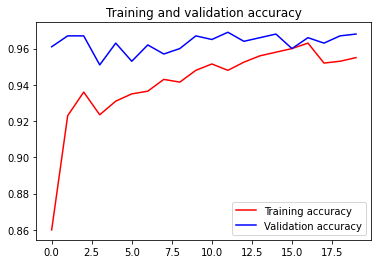

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

###Prediction

In [ ]:
dir = './test'

testFile = os.listdir(dir)
testFile

['cats2.jpg',
 'dogs2.jpg',
 'dogs3.webp',
 'dogs1.jpg',
 'cats5.jpg',
 'dogs5.jpeg',
 'cats.png',
 'cats4.webp',
 'cats3.webp',
 'dogs4.jpg']

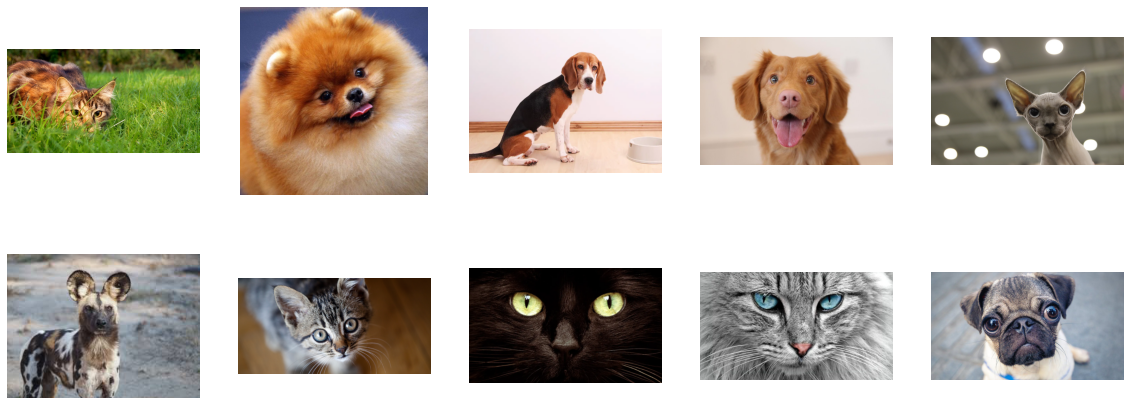

In [ ]:
import matplotlib.image as mpimg

fig = plt.gcf()
fig.set_size_inches(5 * 4, 5 * 4)

next_pix = [os.path.join(dir, fname) for fname in testFile]

for i, img_path in enumerate(next_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(5, 5, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import numpy as np

for i, fn in enumerate(testFile):

  path = os.path.join(dir, fn)
  img = load_img(path, target_size=(150, 150, 3))
  x = img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

1/1 [==============================] - 0s 140ms/step
[0.00492318]
cats2.jpg is a cat
1/1 [==============================] - 0s 168ms/step
[0.99999887]
dogs2.jpg is a dog
1/1 [==============================] - 0s 139ms/step
[1.]
dogs3.webp is a dog
1/1 [==============================] - 0s 161ms/step
[1.]
dogs1.jpg is a dog
1/1 [==============================] - 0s 149ms/step
[0.01516837]
cats5.jpg is a cat
1/1 [==============================] - 0s 145ms/step
[0.99995244]
dogs5.jpeg is a dog
1/1 [==============================] - 0s 148ms/step
[2.878314e-16]
cats.png is a cat
1/1 [==============================] - 0s 150ms/step
[2.2362842e-18]
cats4.webp is a cat
1/1 [==============================] - 0s 147ms/step
[3.4377756e-16]
cats3.webp is a cat
1/1 [==============================] - 0s 163ms/step
[0.9999933]
dogs4.jpg is a dog


All the test case are perfectly predicted